#### 生成线性方程组的哈密顿量，并使用 VQE 求解得到基态及其基态能量，初始参数随机生成。

In [1]:
# 导入必要的库
import time
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from pennylane import numpy as qml_np

import VQE_until
import hamiltonian_until

##### 使用 VQE 进行求解

In [2]:
# 参数设置
steps = 200  # 迭代次数
eta = 0.4  # 学习率
seed = 2048 # 种子数
tol = 1e-4 # 终止条件
deep_layer = 1 # 电路层数


# 量子数
tol_qubits = hamiltonian_until.tol_qubits


# 构造量子设备，不进行量子测量
dev = qml.device("lightning.qubit", wires=tol_qubits, shots=None)
# 定义损失函数
cost_fn = VQE_until.variational_circuit_expval
# 创建运行节点
qnode = qml.QNode(cost_fn, dev)


# 优化器
# opt = qml.GradientDescentOptimizer(stepsize=eta)
opt = qml.AdamOptimizer(stepsize=eta)


# 生成随机的参数
qml_np.random.seed(seed)
params = qml_np.random.uniform(low=0, high=2*np.pi, size=(deep_layer * tol_qubits,))
print("params = ", params)

params =  [3.70464424 0.85958082 4.15965008 6.20230976 5.63890652 3.63767986
 0.40771267 0.68193054 2.81191313 2.12668968 2.02620423 5.69293231]


In [3]:

# 存储损失值和参数
cost_history = []
params_history = [params]

for it in range(steps):
    
    start = time.time()
    
    # 输入可运行节点，用于迭代训练
    params_lsit, cost = opt.step_and_cost(qnode, params, deep_layer)
    # print("params_lsit = ", params_lsit)
    # print("cost = ", cost)

    # 返回来的 list，包含参数和deep_layer等
    params = params_lsit[0]
    # 存储每一次更新后的参数及损失值
    params_history.append(params)
    cost_history.append(cost)
    
    end = time.time()
    
    if it % 2:
        print(f"Step = {it},  Energy = {cost_history[-1]:.8f}, Time = {end - start}")

    # 终止条件
    if len(cost_history) !=1 and abs(cost_history[-1] - cost_history[-2]) < tol:
        break    
    
# 上述存储过程，energy_list 比 params_list 少了最后一项       
cost_history.append(qnode(params, deep_layer))

print("\n" f"Final value of the ground-state energy = {cost_history[-1]:.8f}")
print("\n" f"Optimal value of the circuit parameter = {params_history[-1]}")

Step = 1,  Energy = 10634.18316002, Time = 1.8963730335235596
Step = 3,  Energy = 6474.30737616, Time = 1.5081772804260254
Step = 5,  Energy = 3977.46089200, Time = 1.4584808349609375
Step = 7,  Energy = 2593.42845705, Time = 1.7347908020019531
Step = 9,  Energy = 2585.66001299, Time = 1.6617169380187988
Step = 11,  Energy = 2152.92703369, Time = 1.5437557697296143
Step = 13,  Energy = 888.82724228, Time = 1.7182765007019043
Step = 15,  Energy = 1084.14575827, Time = 1.5472044944763184
Step = 17,  Energy = 1188.51162242, Time = 1.4704546928405762
Step = 19,  Energy = 687.01001723, Time = 1.8144733905792236
Step = 21,  Energy = 441.48405080, Time = 1.5909807682037354
Step = 23,  Energy = 489.77319489, Time = 1.7347745895385742
Step = 25,  Energy = 459.27561204, Time = 1.481149673461914
Step = 27,  Energy = 328.70306766, Time = 1.5839409828186035
Step = 29,  Energy = 128.52619757, Time = 1.4137122631072998
Step = 31,  Energy = 263.96733193, Time = 1.5196702480316162
Step = 33,  Energy = 

abs error =  110.00114271518817


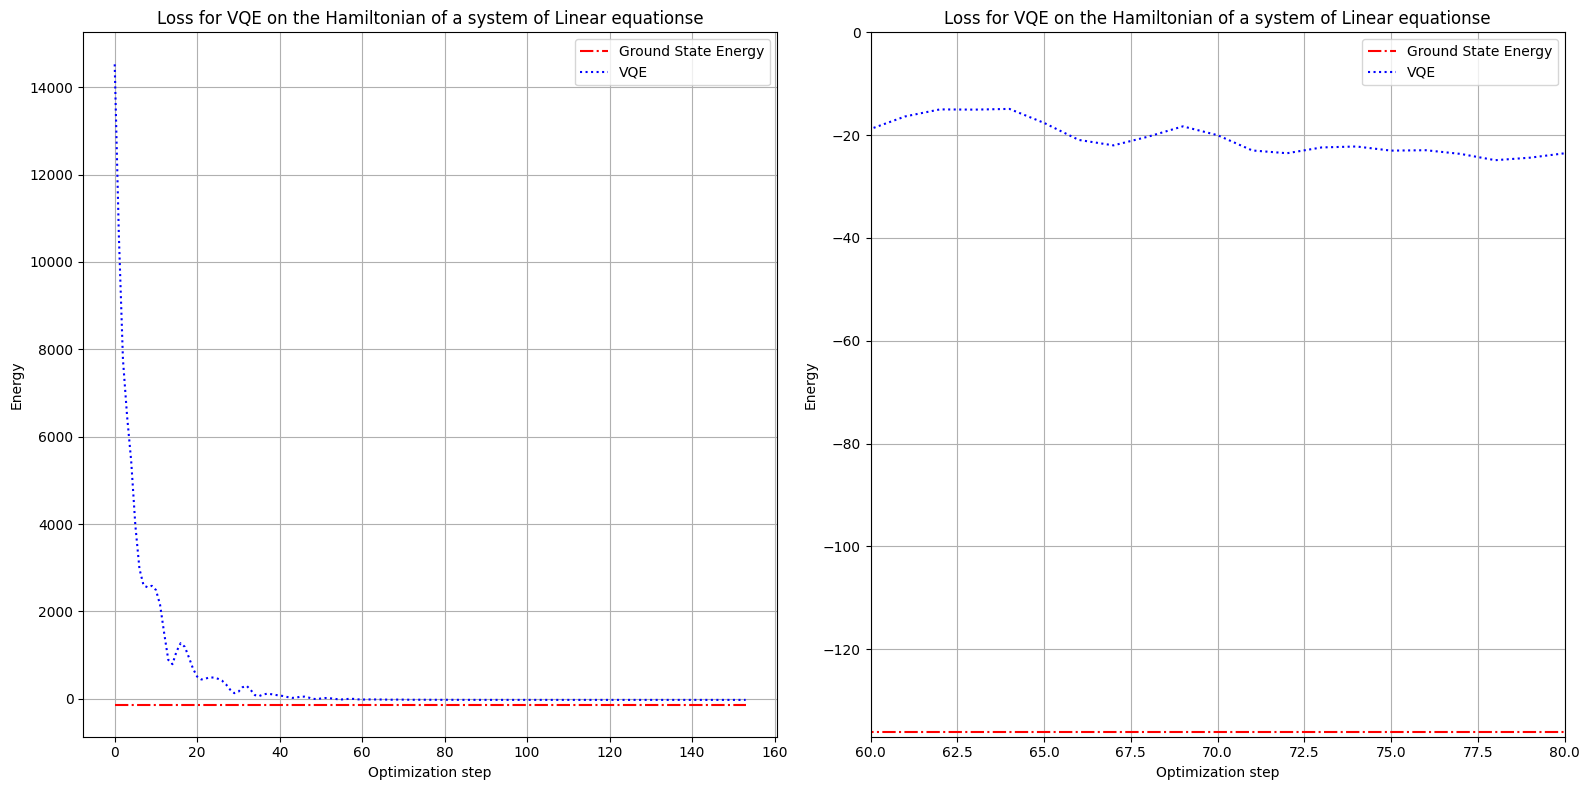

In [4]:
min_eigenvalue = hamiltonian_until.min_eigenvalue
hamiltonian_matrix_real = hamiltonian_until.hamiltonian_matrix_real

print("abs error = ", abs(min_eigenvalue - cost_history[-1]))

# 创建子图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# 第一个子图：完整图
ax1.grid()
ax1.plot(range(it + 2), np.full(it + 2, min_eigenvalue), color='r', linestyle='-.', label='Ground State Energy')
ax1.plot(range(it + 2), cost_history, color='b', linestyle=':', label='VQE')

ax1.set_xlabel('Optimization step')
ax1.set_ylabel('Energy')
ax1.legend()
ax1.set_title('Loss for VQE on the Hamiltonian of a system of Linear equationse')

# 第二章子图，则是截断横纵坐标，展示细节
ax2.grid()
ax2.plot(range(it + 2), np.full(it + 2, min_eigenvalue), color='r', linestyle='-.', label='Ground State Energy')
ax2.plot(range(it + 2), cost_history, color='b', linestyle=':', label='VQE')

# 手动设置纵坐标范围
ax2.set_xlim(60, 80)
ax2.set_ylim(-137, 0)
ax2.set_xlabel('Optimization step')
ax2.set_ylabel('Energy')
ax2.legend()
ax2.set_title('Loss for VQE on the Hamiltonian of a system of Linear equationse')

plt.tight_layout()
plt.show()



In [5]:
# 正确答案的量子态
min_eigenvector = hamiltonian_until.min_eigenvector

# 变分电路学到的量子态
# 构造运行节点
qnode_state = qml.QNode(VQE_until.variational_circuit_state, dev)
circuit_state = qnode_state(params_history[-1], deep_layer)

# 量子态的测量概率
q_probs = circuit_state ** 2

# 查看正确基态的概率
print("prob 940 = ", q_probs[940].real)

print("与正确基态的内积 = ", (circuit_state.reshape(1,-1).conj() @ min_eigenvector.reshape(-1,1)))

prob 940 =  3.4159568882150645e-53
与正确基态的内积 =  [[5.8446188e-27+0.j]]


In [6]:
pro_max_idx = np.argmax(circuit_state)
state_pro_max = circuit_state[pro_max_idx]
state_bin = hamiltonian_until.binary_conversion(circuit_state)

max_idx = np.argmax(state_bin[1])
max_sate_bin = state_bin[0][max_idx]

matrix_value = hamiltonian_matrix_real[pro_max_idx, pro_max_idx]

print("pro_max_idx = ", pro_max_idx)
print("量子态中概率最大的基态，其概率 = ", state_pro_max)
# 即是 pro_max_idx 的二进制表示
print("该概率最大的基态的二进制表示 = ", max_sate_bin)
print("哈密顿量矩阵上对应的对角元 = ", matrix_value)

pro_max_idx =  2018
量子态中概率最大的基态，其概率 =  (0.9999999451486798+0j)
该概率最大的基态的二进制表示 =  011111100010
哈密顿量矩阵上对应的对角元 =  -26.0
